# Linear SVR for approximation of the fundamental matrices of image pairs
### to learn the ropes of the evaluation metric and establish our first (definitely bad) baseline model

## The general Task:

- The datasets are large and a baseline model which is not a neural network is definitely going to have a hard time here. We came up with the idea of applying an SVM to solve for the fundamental matrices of the image pairs.
- Due to the sheer size of the data (over 1.4 million pairings), the fact that for each pairing, a set of 2 images per pair (already resized by us to 150*150 px, resulting in 150x150 _px_ x3 _colors_ = 67500 features) and the fact that SVMs tend to become slower the larger the datasets become, we decided to only work with a small subsample of the data

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
import model
import validation
import matplotlib.pyplot as plt

the list "scenes" tells the code, which scenes to load (see *list of all scenes* below)

In [3]:
input_dir = '../../data/train/' # directory of the training data

allscenes = ["british_museum", "brandenburg_gate", "buckingham_palace",
 "colosseum_exterior", "grand_place_brussels", "lincoln_memorial_statue",
 "notre_dame_front_facade", "pantheon_exterior", "piazza_san_marco",
 "sacre_coeur", "sagrada_familia", "st_pauls_cathedral", "st_peters_square",
 "taj_mahal", "temple_nara_japan", "trevi_fountain"]

scenes=["british_museum", "brandenburg_gate", "buckingham_palace",
 "colosseum_exterior", "grand_place_brussels", "lincoln_memorial_statue",
 "notre_dame_front_facade", "pantheon_exterior", "piazza_san_marco",
 "sacre_coeur", "sagrada_familia", "st_pauls_cathedral", "st_peters_square",
 "taj_mahal", "temple_nara_japan", "trevi_fountain"]



In [4]:
def load_pairs_and_cal(scenes, datadir):
    
    """
    load the image data from the correcsponding directory, together with the pairing metrics.
    Args:
        scenes:     List of scenes (folder names under /train)
        datadir:    String of the directory to source image data from

    Returns:
        pair: dataframe containing the image pairings
        calibration: dataframe contaaining the calibration data per image, including the corresponding scene
    """
    pair = pd.DataFrame()    
    calibration = pd.DataFrame()
    # path which contains all the categories of images
    j = 0
    for scene in scenes:
        print(f'loading category {j+1} of {len(scenes)}: {scene}')
        j += 1

        # read and concatenate pairing datasets. add the "scene" column.
        pairpath = os.path.join(datadir,scene,"pair_covisibility.csv")
        if pair.empty:
            pair = pd.read_csv(pairpath)
        else:
            pairappend = pd.read_csv(pairpath)
            pair = pd.concat([pair,pairappend],axis=0)

        # read and concatenate calibration data, add the "scene" column.
        calibrationpath = os.path.join(datadir,scene,"calibration.csv")
        if calibration.empty:
            calibration = pd.read_csv(calibrationpath)
            calibration["scene"] = str(scene)
        else:
            calibrationappend = pd.read_csv(calibrationpath)
            calibrationappend["scene"] = str(scene)
            calibration = pd.concat([calibration,calibrationappend],axis=0)

    return pair, calibration

In [5]:
pairings, calibration = load_pairs_and_cal(scenes,input_dir)
scalings = pd.read_csv(os.path.join(input_dir, "scaling_factors.csv"))


loading category 1 of 16: british_museum
loading category 2 of 16: brandenburg_gate
loading category 3 of 16: buckingham_palace
loading category 4 of 16: colosseum_exterior
loading category 5 of 16: grand_place_brussels
loading category 6 of 16: lincoln_memorial_statue
loading category 7 of 16: notre_dame_front_facade
loading category 8 of 16: pantheon_exterior
loading category 9 of 16: piazza_san_marco
loading category 10 of 16: sacre_coeur
loading category 11 of 16: sagrada_familia
loading category 12 of 16: st_pauls_cathedral
loading category 13 of 16: st_peters_square
loading category 14 of 16: taj_mahal
loading category 15 of 16: temple_nara_japan
loading category 16 of 16: trevi_fountain


In [6]:
calibration

,image_id,camera_intrinsics,rotation_matrix,translation_vector,scene
0,96255967_5091378744,8.59689453e+02 0.00000000e+00 5.35500000e+02 0...,9.99891678e-01 -1.33539542e-02 6.18909449e-03 ...,-6.30413738e-01 -2.09383535e-01 -9.73421015e-01,british_museum
1,42219277_428722452,8.44582458e+02 0.00000000e+00 5.31000000e+02 0...,9.97685713e-01 -1.30963354e-02 6.67210940e-02 ...,-2.37605901e+00 2.88211093e-01 2.70707623e+00,british_museum
2,10725166_210986135,5.28298767e+02 0.00000000e+00 2.56000000e+02 0...,9.98152782e-01 -3.16456041e-02 5.18611653e-02 ...,-2.27119169e+00 6.73166892e-02 1.84570935e+00,british_museum
3,50084748_4116974413,1.16656165e+03 0.00000000e+00 5.30500000e+02 0...,9.99766659e-01 -1.90689108e-02 -1.01491435e-02...,-6.63296507e-01 1.45779139e-01 4.57227935e-01,british_museum
4,66393650_5300086486,9.91861450e+02 0.00000000e+00 5.10000000e+02 0...,9.98476842e-01 -1.77581448e-02 5.22364245e-02 ...,-2.83293685e+00 -5.72882855e-03 -2.83308355e-01,british_museum
...,...,...,...,...,...
701,02581730_8151291160,8.56864014e+02 0.00000000e+00 3.47000000e+02 0...,9.90124897e-01 -4.71174648e-02 -1.32032697e-01...,1.03693602e+00 5.61571480e-02 9.84726727e-02,trevi_fountain
702,40184297_2989394429,1.06278186e+03 0.00000000e+00 3.89000000e+02 0...,9.99936906e-01 -8.32179083e-03 -7.54537654e-03...,1.05185800e-01 -1.05518102e+00 -1.35282347e+00,trevi_fountain
703,45028253_4526518169,7.44483643e+02 0.00000000e+00 1.02000000e+02 0...,9.98800080e-01 -3.12105707e-02 -3.77399081e-02...,3.51829579e-01 1.70568331e+00 6.31627688e+00,trevi_fountain
704,66225128_7739308762,7.84798523e+02 0.00000000e+00 3.37000000e+02 0...,9.91486213e-01 1.07817217e-02 -1.29764574e-01 ...,1.20354727e+00 -8.15005057e-01 -1.11283145e+00,trevi_fountain


In [7]:
pairings

,pair,covisibility,fundamental_matrix
0,93658023_4980549800-77723525_5227836172,0.852,1.06093615e-03 9.46438466e-02 -5.40808291e+01 ...
1,93658023_4980549800-42803655_6429621523,0.846,6.23570537e-03 -1.34283767e+00 6.89519259e+02 ...
2,77723525_5227836172-69960354_6519615529,0.819,-1.08832894e-01 -4.38808860e+00 2.62340512e+03...
3,77723525_5227836172-42803655_6429621523,0.823,3.66899294e-03 -2.00963144e+00 1.04914787e+03 ...
4,19254317_158538587-18486676_4996206525,0.813,3.02953840e-03 3.28935263e-01 -8.58941061e+01 ...
...,...,...,...
248860,61223743_3150830063-49526651_4313316394,0.000,-3.11287848e-01 -3.78785669e+00 1.90332228e+03...
248861,61223743_3150830063-57483850_8143888888,0.065,-6.03911030e-01 -5.88136724e+00 3.19475581e+03...
248862,61356448_1422536267-45193054_8818019758,0.045,9.15015123e-01 -9.16312393e+00 7.88887558e+03 ...
248863,61356448_1422536267-51302065_4767762595,0.087,-3.15207536e-02 -1.51219066e+00 1.58840706e+03...


In [8]:
scalings

,scene,scaling_factor
0,british_museum,2.517
1,brandenburg_gate,7.380
2,buckingham_palace,18.750
3,colosseum_exterior,36.990
4,grand_place_brussels,10.260
5,lincoln_memorial_statue,1.850
6,notre_dame_front_facade,1.360
7,pantheon_exterior,5.410
8,piazza_san_marco,7.920
9,sacre_coeur,20.270


In [9]:
K = np.array(calibration.iloc[0,1].split()).reshape(3,3).astype(float)
R = np.array(calibration.iloc[0,2].split()).reshape(3,3).astype(float)
T = np.array(calibration.iloc[0,3].split()).reshape(3,1).astype(float)

In [10]:
def plot_3D_perspective_in_2D(R,T, scene="", scale = 1, color=None, alpha = 1):
    if scene != "":
        scale = scalings.query("scene == @scene")["scaling_factor"]
    position = np.dot(-R.T, T)
    rotation = R.T
    C_x = position[0]*scale
    C_y = position[1]*scale
    C_z = position[2]*scale
    # R_x = np.arctan2(rotation[2][1], rotation[2][2])*-180/np.pi
    R_y = np.arctan2(-rotation[2][0], np.sqrt((rotation[2][1]**2)+(rotation[2][2]**2)))*-180/np.pi
    # R_z = np.arctan2(rotation[1][0], rotation[0][0])*-180/np.pi
    return plt.plot(C_x, C_z, marker=(2, 1, R_y), markersize=20, linestyle='None', color=color, alpha=alpha)



In [11]:
plt.colormaps()

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viridis_r',
 'cividis_r',
 'twilight_r',
 'twilight

In [19]:
import plotly.graph_objects as go

x = np.random.uniform(low=3, high=6, size=(5,))
labeltext = ["foo", "bar", "bla", "blubb", "usw"]
y = np.random.uniform(low=3, high=6, size=(5,))

angles = np.random.uniform(low=0, high=2*np.pi, size=(5,))
x_dir = 0.1*np.cos(angles) + x
y_dir = 0.1*np.sin(angles) + y

# Build figure
fig = go.Figure()
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
hover_dicts = [
    {
            "text": labeltext,
            "hovertemplate":
                f"<b>{labeltext}</b><br/>Population: foo",
    },
    {
            "hoverinfo": 'skip',
    }
]
for x_, y_, s, c, line_c, hover_dict in [(x, y, 20, 'LightSkyBlue', 'blue', hover_dicts[0]), (x_dir, y_dir, 5, 'red', 'red', hover_dicts[1])]:
    fig.add_trace(
        go.Scatter(
            mode='markers',
            x=x_,
            y=y_,
            marker=dict(
                color=c,
                size=s,
                line=dict(
                    color=line_c,
                    width=2
                ),
                symbol='triangle-up'
            ),
            showlegend=False,
            **hover_dict
        )
    )
fig.show()

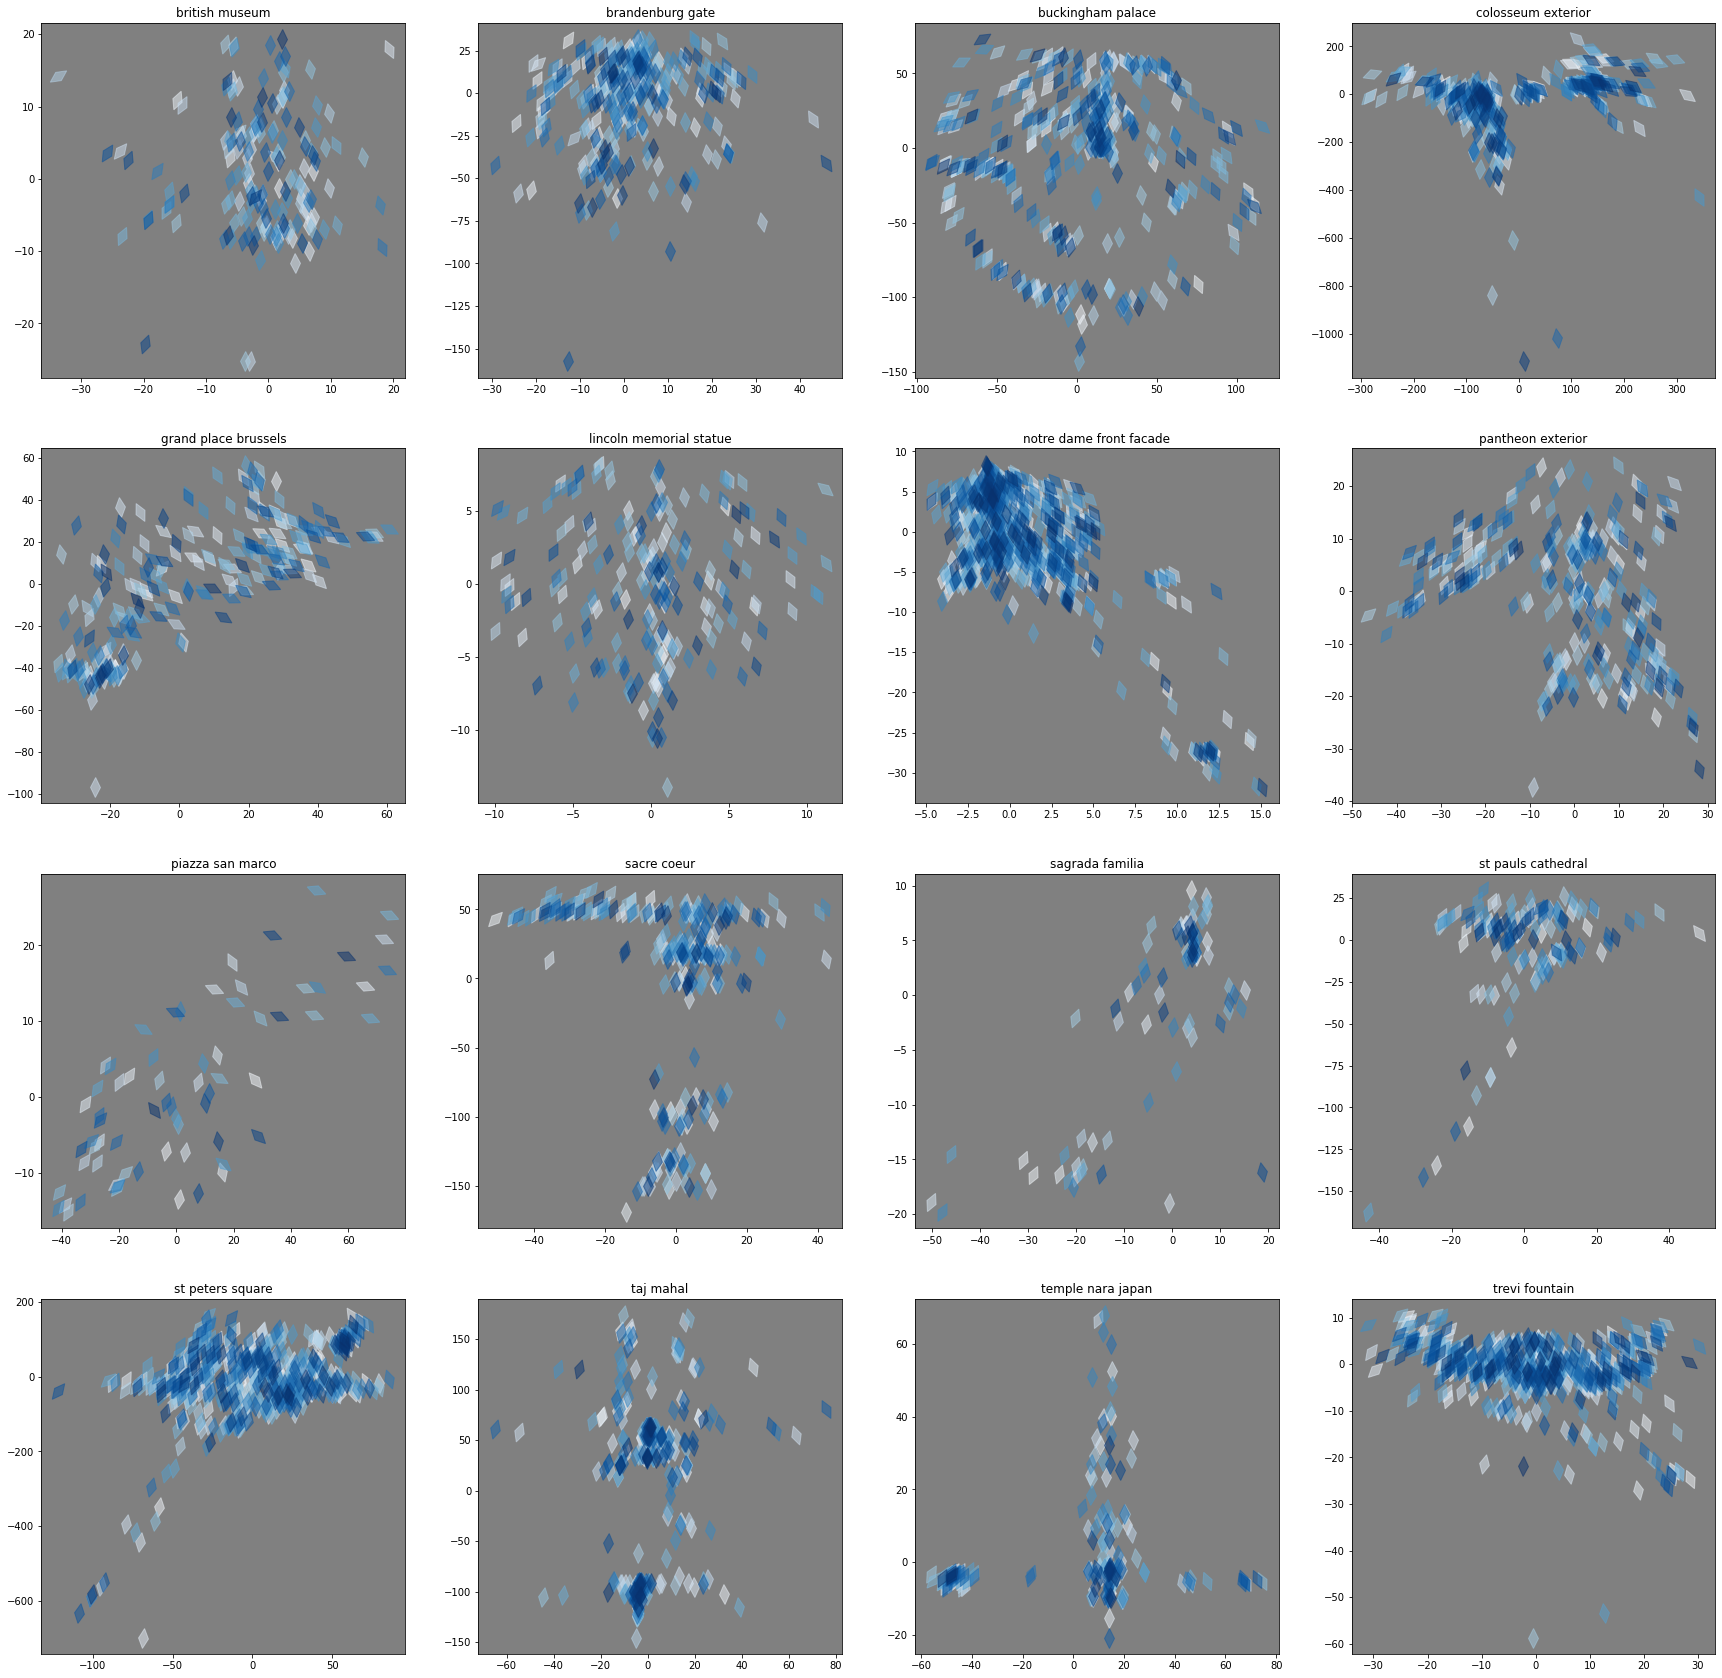

In [17]:

plt.figure(figsize=[30,30])
for i, scene in enumerate(allscenes):
    # construct scene-specific lists of calibration factors, rotational matrices and translational vectors.
    cal = calibration.query("scene == @scene")
    Rs = [np.array(cal.iloc[i,2].split()).reshape(3,3).astype(float) for i in range(cal.shape[0])]
    Ts = [np.array(cal.iloc[i,3].split()).reshape(3,1).astype(float) for i in range(cal.shape[0])]

    sp = plt.subplot(4,4,i+1)
    sp.set_facecolor("grey")
    sp.set_title(scene.replace("_", " "))
    col = iter(plt.cm.Blues(np.linspace(0, 1, cal.shape[0])))
    for i,R,T in zip(range(len(Rs)),Rs, Ts):
        plot_3D_perspective_in_2D(R,T,scene, color=next(col), alpha= 0.5)#color=next(col))
plt.show()

In [ ]:
x = [1,2,3]
for i in x:
    plt.plot(i, i, marker=(3, 0, i*90), markersize=20, linestyle='None')

plt.xlim([0,4])
plt.ylim([0,4])

plt.show()

First, the corresponding dataframes, containing either image pairs or processed 150x150 images with their image IDs are loaded:

In [ ]:
df, images = model.load_scenes(scenes, input_dir)

Train-test-Split.

In [ ]:
x= df[["image1_id", "image2_id","pair", "building"]]
y= df[["fm1","fm2","fm3","fm4","fm5","fm6","fm7","fm8","fm9"]]

x_train, x_test, y_train, y_test = train_test_split(x,y, train_size= 0.2, shuffle=True, random_state=0)

The training dataset is _only_ n = 500 pairings, although even a scene with only 300 images contains pairing data for (300^2)/2= *61250* image pairs. each of which containing *67500* features. 

Without dimensionality reduction, this otherwise takes a LOT of time.

In [ ]:
n = 250
x_train_short = x_train[0:min(n,x_train.shape[0])]
y_train_short = y_train[0:min(n,y_train.shape[0])]
x_test_short = x_test[0:min(n*5,x_test.shape[0])]
y_test_short = y_test[0:min(n*5,y_test.shape[0])]

The Prediction is performed with 9 separately initialized LinearSVR models. these don't communicate with each other, as opposed to models capable of classifying/regressing for multiples targets.

In [ ]:
y_pred = model.fit_pred_9xLinSVR(x_train_short,x_test_short,y_train_short, images)

for the imported evaluation metrics to properly work, some adjustments to the formatting need to be done:

In [ ]:

fund_matrix_list_all = [list((y_pred.iloc[1])[0:9]) for i in range(y_pred.shape[0])]
fund_matrix_list_all = [" ".join([str(num) for num in fundmatrix]) for fundmatrix in fund_matrix_list_all]
sample_id_list_all = [";".join(["phototourism",scene,pair]) for scene, pair in zip(x_test_short.iloc[:,3],x_test_short.iloc[:,2])]

validation metrics are used, as demonstrated in https://www.kaggle.com/code/tmyok1984/imc2022-validation-code/notebook

In [ ]:
maa = validation.evaluate(input_dir, sample_id_list_all, fund_matrix_list_all)
print(f'mAA={maa:.05f} (n={len(sample_id_list_all)})')

as is apparent, the accuracy is abysmal.
The main reasons for this are probably:
- the small sample size, as explained above. Only using a small fraction of the actual data does not deliver an appropriate model, probably introducing bias.
- the model is too simple: although the predictor consists of 9 different SVMs, each fitting for every single pixel color channel, this is far from sophisticated enough to grasp the relative movement of objects within the images. This introduces even more bias.
- The data format here is extremely limiting to the applicability and clearly not appropriate for the dimensionality of the images. Actually using all provided data might take several days to compute, with a very limited chance of success. A proper dimensionality reduction is necessary for handling the image datasets.
- The data need sanitising first. I.e. images with a covisibility below 0.1 are not recommended for training, as stated by the competition hosts. Such image pairs are having insufficient overlap (or none at all). this weakens the model's predictive power even further. Additionally, small thumbnail images provide too little feature information to classify them properly.
